In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:

# --- 1. Load Feature Names ---
# This step is needed to get the 'features' variable you used.
# We read the 2nd column (index 1) from features.txt.
try:
    features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
    feature_names = features_df[1].tolist()
except FileNotFoundError:
    print("Error: 'features.txt' not found. Make sure it's in the 'UCI HAR Dataset' folder.")
    # You would typically exit or handle this error, but for demonstration:
    feature_names = [] # Set to empty list to show the error

# --- 2. Load Training Data (X_train) ---
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Set the column names
if feature_names:
    X_train.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: Feature names not loaded. Columns will be numbered.")

# --- 3. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)[0]

# --- 4. Load Activity Labels (y_train) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_train_series = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])['Activity']

# --- 5. Combine All Data into One DataFrame ---
# It's good practice to copy X_train to avoid modifying the original
train = X_train.copy()

# Add the new columns
train['subject'] = subject_series
train['Activity'] = y_train_series

# --- 6. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

train['ActivityName'] = train['Activity'].map(activity_map)

# --- 7. Display a Sample ---
# Using .head() or .sample() is a great way to check your work
print("Data loaded successfully. Displaying first few data set:")
train.head(2)



C:\Users\new user\AppData\Local\Temp\ipykernel_14320\1967201394.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
C:\Users\new user\AppData\Local\Temp\ipykernel_14320\1967201394.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


Data loaded successfully. Displaying first few data set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


In [3]:
# --- 1. Load Test Data (X_test) ---
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Set the column names
if 'feature_names' in locals():
    X_test.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: 'feature_names' not found. Columns will be numbered.")

# --- 2. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series_test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)[0]

# --- 3. Load Activity Labels (y_test) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_test_series = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])['Activity']

# --- 4. Combine All Data into One DataFrame ---
# Use .copy() to prevent SettingWithCopyWarning
test = X_test.copy()

# Add the new columns
test['subject'] = subject_series_test
test['Activity'] = y_test_series

# --- 5. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

test['ActivityName'] = test['Activity'].map(activity_map)

# --- 6. Display a Sample ---
print("Test data loaded successfully. Displaying a random sample:")
print(test.head(2))


C:\Users\new user\AppData\Local\Temp\ipykernel_14320\2637941692.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


Test data loaded successfully. Displaying a random sample:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  angle(tBodyAccMean,gravity)  \
0         -0.674302         -0.894088  ...                     0.006462   
1         -0.945823         -0.894088  ...                    -0.083495   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                               0.16292                         -0.825886   
1                               0.01750                         -0.434375   

   angle(t

In [4]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [5]:
#Labels that are useful in plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
#Let's make a function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    
    # --- THIS IS THE FIX ---
    plt.grid(False) # Changed from plt.grid(b=False)
    # -----------------------
    
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

In [7]:
def print_grid_search_attributes(model):
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))

    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))

    print('\n==> No. of CrossValidation sets:')
    print('\tTotal number of cross validation sets: {}'.format(model.n_splits_))

    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))
    
    # If it's a pipeline, show the dimensionality reduction info
    if hasattr(model.best_estimator_, 'named_steps'):
        if 'dim_red' in model.best_estimator_.named_steps:
            dim_red_model = model.best_estimator_.named_steps['dim_red']
            if hasattr(dim_red_model, 'n_components_'):
                print(f'\n==> Dimensionality Reduction:')
                print(f'\tPCA components: {dim_red_model.n_components_}')
            elif hasattr(dim_red_model, 'n_components'):
                print(f'\n==> Dimensionality Reduction:')
                print(f'\tLDA components: {dim_red_model.n_components}')

    

Running GridSearchCV for PCA + Random Forest...
Training the RF with PCA model..
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Done....!

==> Training time:- 0:02:12.146122

Predicting test data
Done....!

==> Testing time:- 0:00:00.071361

==> Accuracy:- 0.8819138106549033


 ********Confusion Matrix********

 [[512  22   3   0   0   0]
 [  2 369 119   0   0   1]
 [  0  34 498   0   0   0]
 [  0   0   0 474  19   3]
 [  0   0   0  61 312  47]
 [  0   0   0  27  10 434]]


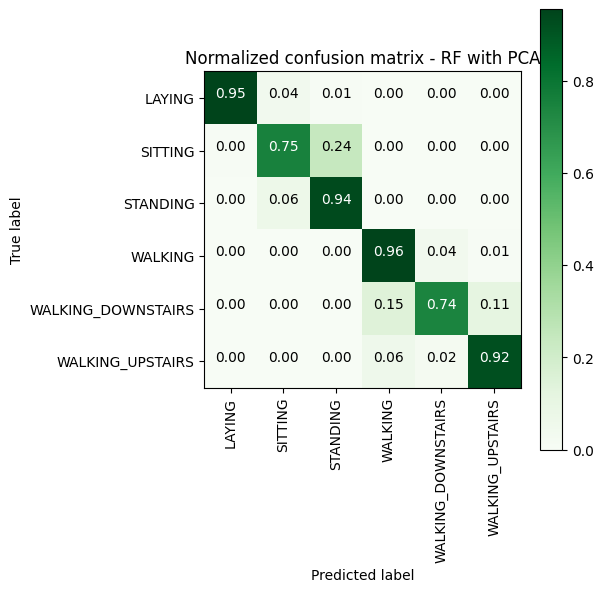

****************| Classification Report - RF with PCA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.95      0.97       537
           SITTING       0.87      0.75      0.81       491
          STANDING       0.80      0.94      0.86       532
           WALKING       0.84      0.96      0.90       496
WALKING_DOWNSTAIRS       0.91      0.74      0.82       420
  WALKING_UPSTAIRS       0.89      0.92      0.91       471

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.88      0.88      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', PCA(n_components=0.95)),
                ('model',
                 RandomForestClassifier(max_depth=15, min_samples_split=5,
                                        n_estimators=150, random_state=42))])


==> Best parameters:
	

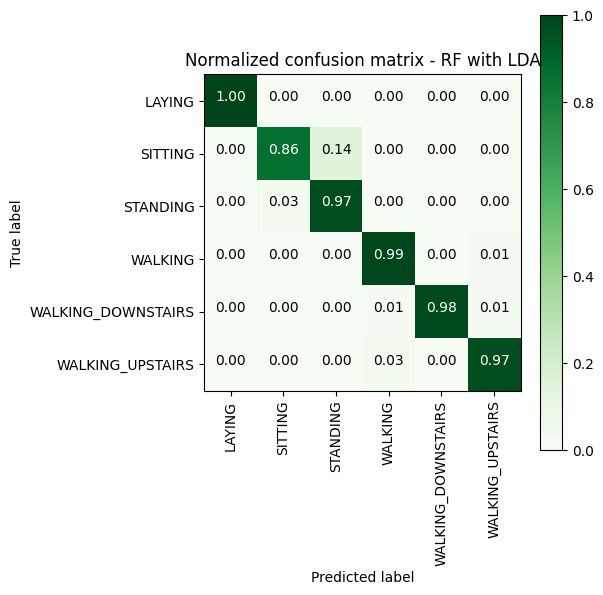

****************| Classification Report - RF with LDA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.86      0.91       491
          STANDING       0.88      0.97      0.92       532
           WALKING       0.97      0.99      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.97      0.97       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', LinearDiscriminantAnalysis(n_components=5)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_split=10,
                                        n_estimators=50, random_state=42))])


==

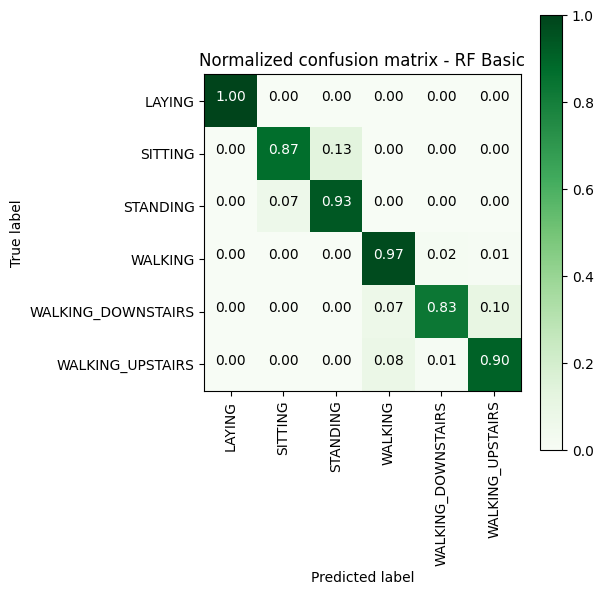

****************| Classification Report - RF Basic |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.87      0.90       491
          STANDING       0.89      0.93      0.91       532
           WALKING       0.88      0.97      0.92       496
WALKING_DOWNSTAIRS       0.96      0.83      0.89       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=4,
                                        n_estimators=50, random_state=42))])


==> Best parameters:
	Parameters of best estimator : {'model__max_depth': 15, 'm

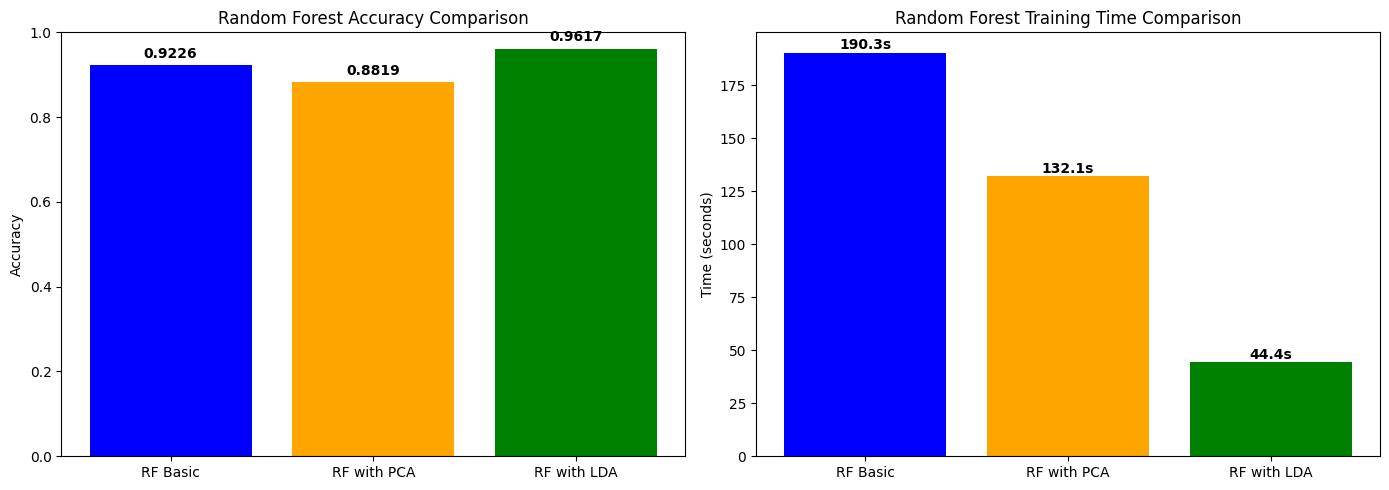


DETAILED RANDOM FOREST COMPARISON
Model                | Accuracy | Training Time | Best Parameters
--------------------------------------------------------------------------------
RF Basic             | 0.9226   | 190.3       s | n_est=50, max_depth=15
RF with PCA          | 0.8819   | 132.1       s | n_est=150, max_depth=15
RF with LDA          | 0.9617   | 44.4        s | n_est=50, max_depth=20

🏆 Best performing Random Forest model: RF with LDA

SIDE-BY-SIDE CONFUSION MATRIX COMPARISON - RANDOM FOREST MODELS


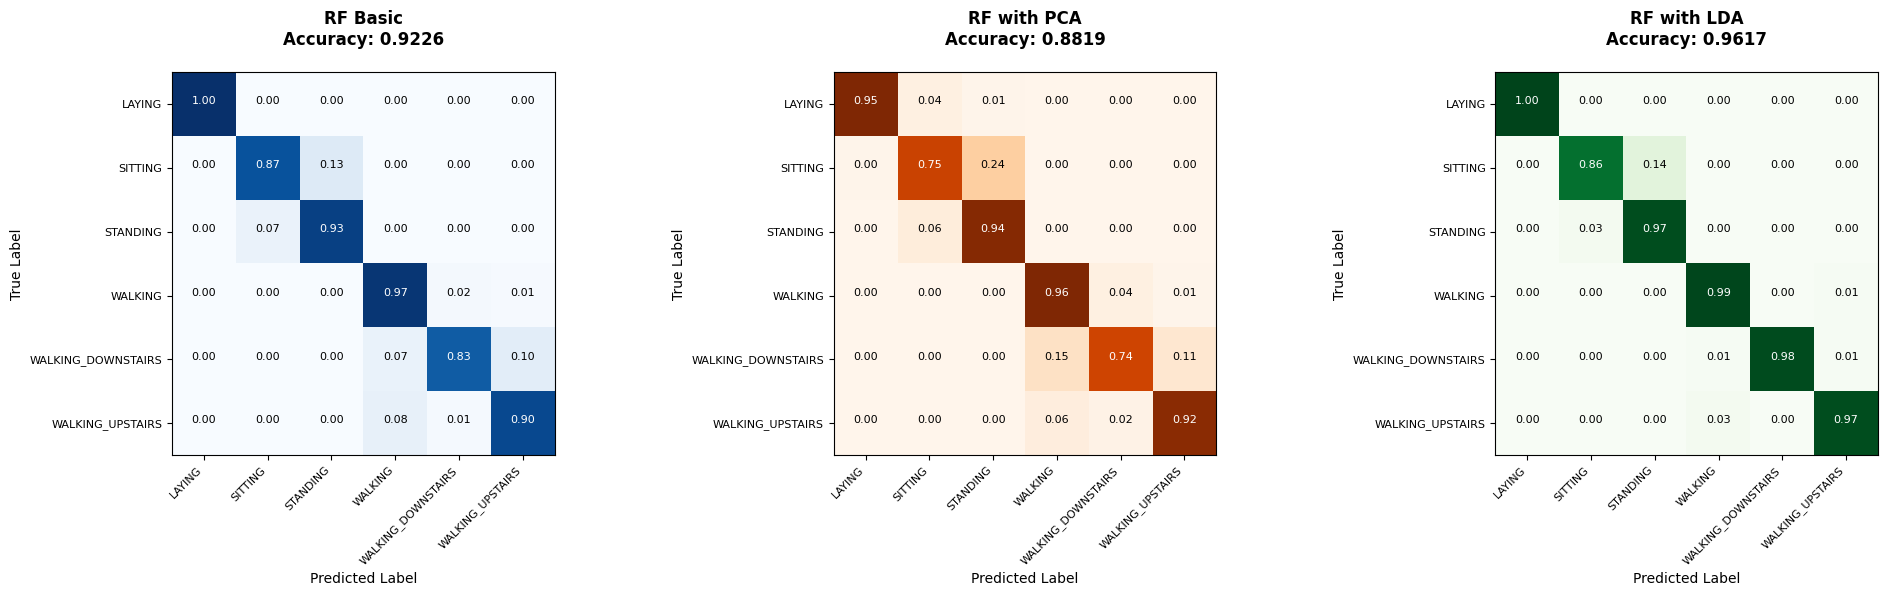


CLASS-WISE PERFORMANCE COMPARISON - RANDOM FOREST
Class                | Basic Prec Basic Rec  Basic F1   | PCA Prec   PCA Rec    PCA F1     | LDA Prec   LDA Rec    LDA F1    
------------------------------------------------------------------------------------------------------------------------
LAYING               | 1.0000     1.0000     1.0000     | 0.9961     0.9534     0.9743     | 1.0000     1.0000     1.0000    
SITTING              | 0.9242     0.8697     0.8961     | 0.8682     0.7515     0.8057     | 0.9634     0.8574     0.9073    
STANDING             | 0.8859     0.9342     0.9094     | 0.8032     0.9361     0.8646     | 0.8821     0.9699     0.9239    
WALKING              | 0.8798     0.9738     0.9244     | 0.8434     0.9556     0.8960     | 0.9666     0.9919     0.9791    
WALKING_DOWNSTAIRS   | 0.9562     0.8310     0.8892     | 0.9150     0.7429     0.8200     | 1.0000     0.9762     0.9880    
WALKING_UPSTAIRS     | 0.9006     0.9045     0.9025     | 0.8948     0.9

In [8]:
# --- Random Forest with Dimensionality Reduction ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Random Forest Implementation ---
def perform_rf_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, 
                     print_cm=True, cm_cmap=plt.cm.Greens, model_name="Random Forest"):
    """
    Perform Random Forest model training and evaluation
    """
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print(f'Training the {model_name} model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print(f'==> Training time:- {results["training_time"]}\n')
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print(f'==> Testing time:- {results["testing_time"]}\n')
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print(f'==> Accuracy:- {accuracy}\n')
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print(f'\n {cm}')
        
    # plot confusion matrix
    plt.figure(figsize=(6,6))
    plt.grid(False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, 
                         title=f'Normalized confusion matrix - {model_name}', cmap=cm_cmap)
    plt.show()
    
    # get classification report
    print(f'****************| Classification Report - {model_name} |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results

# --- Random Forest with PCA ---
print("Running GridSearchCV for PCA + Random Forest...")

# Define RF parameters for grid search
rf_parameters = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create PCA pipeline for RF
pca_rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', PCA(n_components=0.95)),
    ('model', RandomForestClassifier(random_state=42))
])

# Setup GridSearchCV for RF with PCA
rf_grid_pca = GridSearchCV(
    pca_rf_pipeline,
    param_grid=rf_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run RF model with PCA
rf_grid_pca_results = perform_rf_model(
    rf_grid_pca, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="RF with PCA"
)

print_grid_search_attributes(rf_grid_pca_results['model'])

# --- Random Forest with LDA ---
print("\nRunning GridSearchCV for LDA + Random Forest...")

# Create LDA pipeline for RF
lda_rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', LDA(n_components=5)),  # LDA for dimensionality reduction
    ('model', RandomForestClassifier(random_state=42))
])

# Setup GridSearchCV for LDA + RF
rf_grid_lda = GridSearchCV(
    lda_rf_pipeline,
    param_grid=rf_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run LDA + RF model
rf_grid_lda_results = perform_rf_model(
    rf_grid_lda, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="RF with LDA"
)

print_grid_search_attributes(rf_grid_lda_results['model'])

# --- Random Forest without Dimensionality Reduction ---
print("\nRunning GridSearchCV for Random Forest without Dimensionality Reduction...")

# Create RF pipeline without dimensionality reduction
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Setup GridSearchCV for RF without dimensionality reduction
rf_grid_basic = GridSearchCV(
    rf_pipeline,
    param_grid=rf_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run basic RF model
rf_grid_basic_results = perform_rf_model(
    rf_grid_basic, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="RF Basic"
)

print_grid_search_attributes(rf_grid_basic_results['model'])

# --- Random Forest Comparison ---
print("\n" + "="*50)
print("RANDOM FOREST MODEL COMPARISON")
print("="*50)
print(f"RF Basic:               {rf_grid_basic_results['accuracy']:.4f}")
print(f"RF with PCA:            {rf_grid_pca_results['accuracy']:.4f}")
print(f"RF with LDA:            {rf_grid_lda_results['accuracy']:.4f}")

# Extract best parameters for comparison
rf_basic_params = rf_grid_basic_results['model'].best_params_
rf_pca_params = rf_grid_pca_results['model'].best_params_
rf_lda_params = rf_grid_lda_results['model'].best_params_

print("\nBest Parameters:")
print(f"RF Basic: {rf_basic_params}")
print(f"RF with PCA: {rf_pca_params}")
print(f"RF with LDA: {rf_lda_params}")

# --- Random Forest Comparison Visualization ---
rf_models = ['RF Basic', 'RF with PCA', 'RF with LDA']
rf_accuracies = [
    rf_grid_basic_results['accuracy'],
    rf_grid_pca_results['accuracy'],
    rf_grid_lda_results['accuracy']
]

rf_training_times = [
    rf_grid_basic_results['training_time'].total_seconds(),
    rf_grid_pca_results['training_time'].total_seconds(),
    rf_grid_lda_results['training_time'].total_seconds()
]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['blue', 'orange', 'green']
bars1 = ax1.bar(rf_models, rf_accuracies, color=colors)
ax1.set_title('Random Forest Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, rf_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison  
bars2 = ax2.bar(rf_models, rf_training_times, color=colors)
ax2.set_title('Random Forest Training Time Comparison')
ax2.set_ylabel('Time (seconds)')
for bar, time in zip(bars2, rf_training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison
print("\n" + "="*80)
print("DETAILED RANDOM FOREST COMPARISON")
print("="*80)
print(f"{'Model':<20} | {'Accuracy':<8} | {'Training Time':<12} | Best Parameters")
print("-" * 80)

rf_basic_str = f"n_est={rf_basic_params['model__n_estimators']}, max_depth={rf_basic_params['model__max_depth']}"
rf_pca_str = f"n_est={rf_pca_params['model__n_estimators']}, max_depth={rf_pca_params['model__max_depth']}"
rf_lda_str = f"n_est={rf_lda_params['model__n_estimators']}, max_depth={rf_lda_params['model__max_depth']}"

print(f"{'RF Basic':<20} | {rf_accuracies[0]:<8.4f} | {rf_training_times[0]:<12.1f}s | {rf_basic_str}")
print(f"{'RF with PCA':<20} | {rf_accuracies[1]:<8.4f} | {rf_training_times[1]:<12.1f}s | {rf_pca_str}")
print(f"{'RF with LDA':<20} | {rf_accuracies[2]:<8.4f} | {rf_training_times[2]:<12.1f}s | {rf_lda_str}")

# Determine winner
best_accuracy = max(rf_accuracies)
best_model_idx = rf_accuracies.index(best_accuracy)
winner = rf_models[best_model_idx]

print(f"\n🏆 Best performing Random Forest model: {winner}")
print("="*80)

# --- Side-by-Side Confusion Matrix Comparison ---
print("\n" + "="*90)
print("SIDE-BY-SIDE CONFUSION MATRIX COMPARISON - RANDOM FOREST MODELS")
print("="*90)

# Get confusion matrices
cm_basic = rf_grid_basic_results['confusion_matrix']
cm_pca = rf_grid_pca_results['confusion_matrix']
cm_lda = rf_grid_lda_results['confusion_matrix']

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Normalize confusion matrices
cm_basic_normalized = cm_basic.astype('float') / cm_basic.sum(axis=1)[:, np.newaxis]
cm_pca_normalized = cm_pca.astype('float') / cm_pca.sum(axis=1)[:, np.newaxis]
cm_lda_normalized = cm_lda.astype('float') / cm_lda.sum(axis=1)[:, np.newaxis]

# Plot Basic RF Confusion Matrix
im1 = ax1.imshow(cm_basic_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('RF Basic\nAccuracy: {:.4f}'.format(rf_grid_basic_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.set_ylabel('True Label', fontsize=10)
tick_marks = np.arange(len(labels))
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(labels, fontsize=8)

# Add text annotations for Basic RF
thresh = cm_basic_normalized.max() / 2.
for i, j in itertools.product(range(cm_basic_normalized.shape[0]), range(cm_basic_normalized.shape[1])):
    ax1.text(j, i, format(cm_basic_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_basic_normalized[i, j] > thresh else "black",
             fontsize=8)

# Plot PCA RF Confusion Matrix
im2 = ax2.imshow(cm_pca_normalized, interpolation='nearest', cmap=plt.cm.Oranges)
ax2.set_title('RF with PCA\nAccuracy: {:.4f}'.format(rf_grid_pca_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=10)
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(labels, fontsize=8)

# Add text annotations for PCA RF
thresh = cm_pca_normalized.max() / 2.
for i, j in itertools.product(range(cm_pca_normalized.shape[0]), range(cm_pca_normalized.shape[1])):
    ax2.text(j, i, format(cm_pca_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_pca_normalized[i, j] > thresh else "black",
             fontsize=8)

# Plot LDA RF Confusion Matrix
im3 = ax3.imshow(cm_lda_normalized, interpolation='nearest', cmap=plt.cm.Greens)
ax3.set_title('RF with LDA\nAccuracy: {:.4f}'.format(rf_grid_lda_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax3.set_xlabel('Predicted Label', fontsize=10)
ax3.set_ylabel('True Label', fontsize=10)
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax3.set_yticklabels(labels, fontsize=8)

# Add text annotations for LDA RF
thresh = cm_lda_normalized.max() / 2.
for i, j in itertools.product(range(cm_lda_normalized.shape[0]), range(cm_lda_normalized.shape[1])):
    ax3.text(j, i, format(cm_lda_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_lda_normalized[i, j] > thresh else "black",
             fontsize=8)

plt.tight_layout()
plt.show()

# --- Detailed Class-wise Performance Comparison ---
print("\n" + "="*100)
print("CLASS-WISE PERFORMANCE COMPARISON - RANDOM FOREST")
print("="*100)

# Calculate metrics for all models
from sklearn.metrics import precision_recall_fscore_support

precision_basic, recall_basic, f1_basic, _ = precision_recall_fscore_support(y_test, rf_grid_basic_results['predicted'], average=None, labels=labels)
precision_pca, recall_pca, f1_pca, _ = precision_recall_fscore_support(y_test, rf_grid_pca_results['predicted'], average=None, labels=labels)
precision_lda, recall_lda, f1_lda, _ = precision_recall_fscore_support(y_test, rf_grid_lda_results['predicted'], average=None, labels=labels)

print(f"{'Class':<20} | {'Basic Prec':<10} {'Basic Rec':<10} {'Basic F1':<10} | {'PCA Prec':<10} {'PCA Rec':<10} {'PCA F1':<10} | {'LDA Prec':<10} {'LDA Rec':<10} {'LDA F1':<10}")
print("-" * 120)

for i, label in enumerate(labels):
    print(f"{label:<20} | {precision_basic[i]:<10.4f} {recall_basic[i]:<10.4f} {f1_basic[i]:<10.4f} | "
          f"{precision_pca[i]:<10.4f} {recall_pca[i]:<10.4f} {f1_pca[i]:<10.4f} | "
          f"{precision_lda[i]:<10.4f} {recall_lda[i]:<10.4f} {f1_lda[i]:<10.4f}")

# Calculate average metrics
avg_precision_basic = precision_basic.mean()
avg_recall_basic = recall_basic.mean()
avg_f1_basic = f1_basic.mean()

avg_precision_pca = precision_pca.mean()
avg_recall_pca = recall_pca.mean()
avg_f1_pca = f1_pca.mean()

avg_precision_lda = precision_lda.mean()
avg_recall_lda = recall_lda.mean()
avg_f1_lda = f1_lda.mean()

print("-" * 120)
print(f"{'AVERAGE':<20} | {avg_precision_basic:<10.4f} {avg_recall_basic:<10.4f} {avg_f1_basic:<10.4f} | "
      f"{avg_precision_pca:<10.4f} {avg_recall_pca:<10.4f} {avg_f1_pca:<10.4f} | "
      f"{avg_precision_lda:<10.4f} {avg_recall_lda:<10.4f} {avg_f1_lda:<10.4f}")

# --- Best Parameters Summary ---
print("\n" + "="*60)
print("BEST PARAMETERS SUMMARY - RANDOM FOREST")
print("="*60)

print("RF Basic - Best Parameters:")
print(f"  n_estimators: {rf_basic_params['model__n_estimators']}")
print(f"  max_depth: {rf_basic_params['model__max_depth']}")
print(f"  min_samples_split: {rf_basic_params['model__min_samples_split']}")
print(f"  min_samples_leaf: {rf_basic_params['model__min_samples_leaf']}")

print("\nRF with PCA - Best Parameters:")
print(f"  n_estimators: {rf_pca_params['model__n_estimators']}")
print(f"  max_depth: {rf_pca_params['model__max_depth']}")
print(f"  min_samples_split: {rf_pca_params['model__min_samples_split']}")
print(f"  min_samples_leaf: {rf_pca_params['model__min_samples_leaf']}")

print("\nRF with LDA - Best Parameters:")
print(f"  n_estimators: {rf_lda_params['model__n_estimators']}")
print(f"  max_depth: {rf_lda_params['model__max_depth']}")
print(f"  min_samples_split: {rf_lda_params['model__min_samples_split']}")
print(f"  min_samples_leaf: {rf_lda_params['model__min_samples_leaf']}")

# Final recommendation
print("\n" + "="*70)
print("FINAL RECOMMENDATION - RANDOM FOREST")
print("="*70)

# Find the best model
accuracies = [rf_grid_basic_results['accuracy'], rf_grid_pca_results['accuracy'], rf_grid_lda_results['accuracy']]
best_idx = np.argmax(accuracies)
best_model_name = rf_models[best_idx]
best_accuracy = accuracies[best_idx]

print(f"🏆 Best performing Random Forest model: {best_model_name}")
print(f"📈 Best accuracy achieved: {best_accuracy:.4f}")

# Compare with other models
for i, (model, acc) in enumerate(zip(rf_models, accuracies)):
    if i != best_idx:
        advantage = best_accuracy - acc
        print(f"📊 Advantage over {model}: {advantage:.4f} ({advantage*100:.2f}%)")

print("="*70)

# --- Dimensionality Reduction Analysis ---
print("\n" + "="*60)
print("DIMENSIONALITY REDUCTION ANALYSIS")
print("="*60)

# Show the effect of dimensionality reduction
print("Original feature space dimensions:", X_train.shape[1])

# For PCA, show how many components were selected - CORRECTED
pca_model = rf_grid_pca_results['model'].best_estimator_.named_steps['dim_red']
print(f"PCA reduced to {pca_model.n_components_} components "
      f"({pca_model.n_components_/X_train.shape[1]*100:.1f}% of original)")

# For LDA, show fixed number of components - CORRECTED
lda_model = rf_grid_lda_results['model'].best_estimator_.named_steps['dim_red']
print(f"LDA reduced to {lda_model.n_components} components "
      f"({lda_model.n_components/X_train.shape[1]*100:.1f}% of original)")

print("\nDimensionality reduction impact on Random Forest:")
print(f"Basic RF (no reduction): {rf_grid_basic_results['accuracy']:.4f}")
print(f"PCA + RF:                {rf_grid_pca_results['accuracy']:.4f}")
print(f"LDA + RF:                {rf_grid_lda_results['accuracy']:.4f}")


Dimensionality reduction impact on Random Forest:
Basic RF (no reduction): 0.9226
PCA + RF:                0.8819
LDA + RF:                0.9617

Top 30 features by importance:
tGravityAcc-mean()-X               0.042918
angle(X,gravityMean)               0.042394
tGravityAcc-mean()-Y               0.031752
tGravityAcc-min()-X                0.030652
tGravityAcc-max()-Y                0.023798
angle(Y,gravityMean)               0.022972
tGravityAcc-max()-X                0.022220
tGravityAcc-min()-Y                0.019507
tGravityAcc-energy()-Y             0.018071
tGravityAcc-energy()-X             0.017403
tBodyAccJerk-std()-X               0.013792
tBodyAccJerk-sma()                 0.013657
angle(Z,gravityMean)               0.013498
fBodyAccJerk-bandsEnergy()-1,24    0.012939
tBodyGyroJerk-iqr()-Z              0.012858
fBodyAccJerk-bandsEnergy()-1,16    0.012670
fBodyAccJerk-mean()-X              0.012554
fBodyAcc-entropy()-X               0.012496
tGravityAcc-arCoeff()-Z,4    

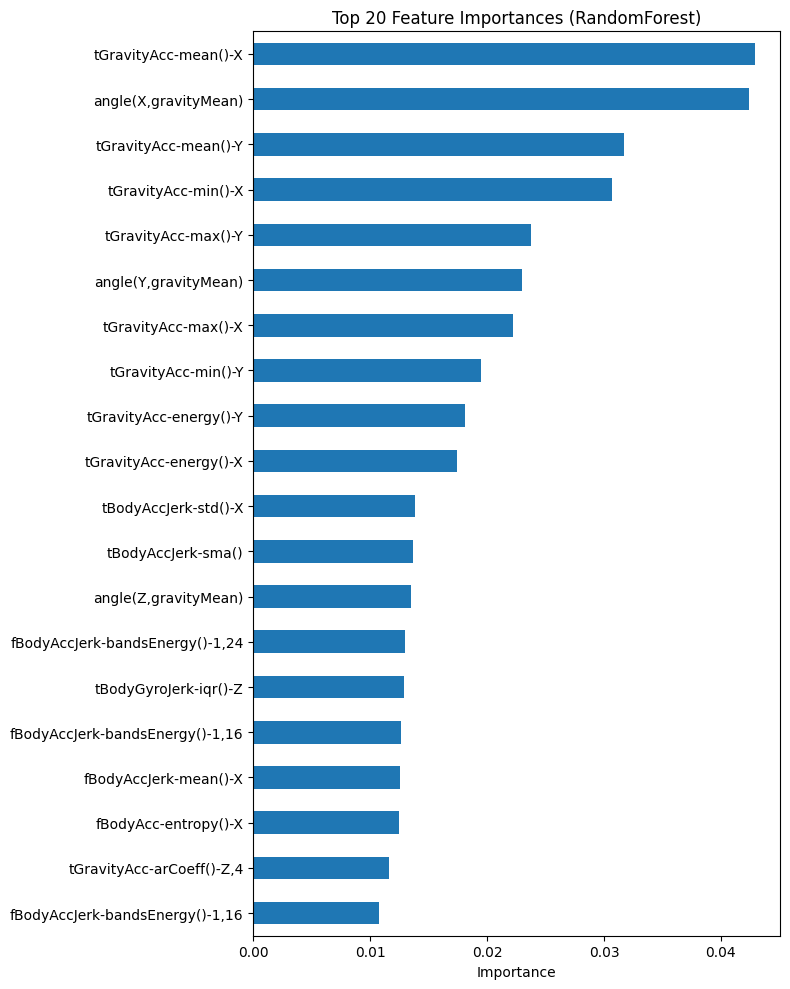

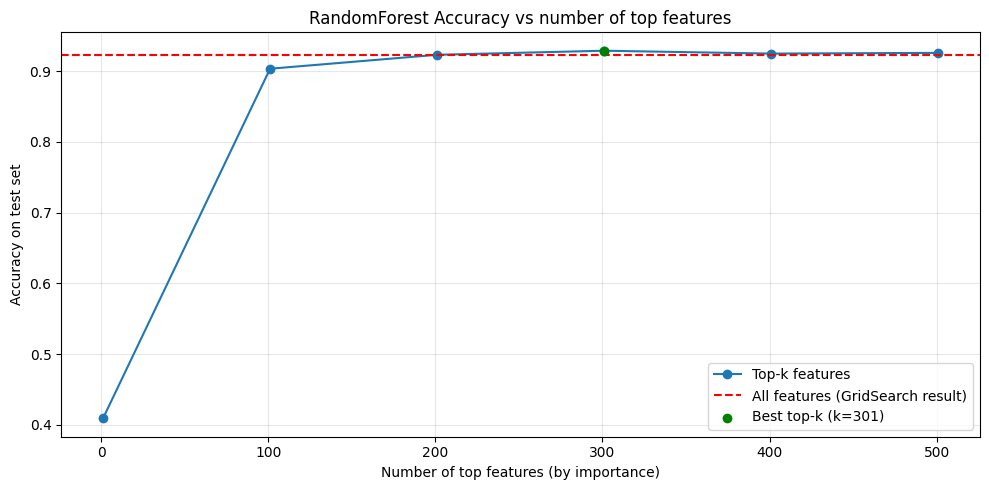


Best accuracy using top-k features: 0.9287 (k=301)
Accuracy using all features (fresh RF): 0.9196
Accuracy using all features (GridSearch): 0.9226


In [11]:
print("\nDimensionality reduction impact on Random Forest:")
print(f"Basic RF (no reduction): {rf_grid_basic_results['accuracy']:.4f}")
print(f"PCA + RF:                {rf_grid_pca_results['accuracy']:.4f}")
print(f"LDA + RF:                {rf_grid_lda_results['accuracy']:.4f}")

# --- FEATURE IMPORTANCE RANKING & ACCURACY VS TOP-K FEATURES ---
# Get the best RandomForest estimator (from RF basic pipeline)
rf_best_estimator = rf_grid_basic_results['model'].best_estimator_.named_steps['model']

# Compute feature importances
importances = pd.Series(rf_best_estimator.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

# Print and plot the top features
print("\nTop 30 features by importance:")
print(importances_sorted.head(30))

plt.figure(figsize=(8, 10))
importances_sorted.head(20).plot(kind='barh', color='tab:blue')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Build incremental accuracy curve: train RF on top-k features (k=1..50)
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Extract best hyperparameters from rf_basic_params (GridSearch)
best_rf_params = {
    'n_estimators': rf_basic_params.get('model__n_estimators', 100),
    'max_depth': rf_basic_params.get('model__max_depth', None),
    'min_samples_split': rf_basic_params.get('model__min_samples_split', 2),
    'min_samples_leaf': rf_basic_params.get('model__min_samples_leaf', 1),
    'random_state': 42,
    'n_jobs': -1
}

ks = list(range(1, 551, 100))
accuracies_topk = []
for k in ks:
    topk_features = importances_sorted.index[:k].tolist()
    rf_k = RandomForestClassifier(**best_rf_params)
    rf_k.fit(X_train[topk_features], y_train)
    y_pred_k = rf_k.predict(X_test[topk_features])
    accuracies_topk.append(accuracy_score(y_test, y_pred_k))

# Evaluate a fresh RF trained on all features for comparison
rf_all = RandomForestClassifier(**best_rf_params)
rf_all.fit(X_train, y_train)
acc_all = accuracy_score(y_test, rf_all.predict(X_test))

# Plot accuracy vs number of top features
plt.figure(figsize=(10, 5))
plt.plot(ks, accuracies_topk, marker='o', label='Top-k features')
plt.axhline(y=rf_grid_basic_results['accuracy'], color='red', linestyle='--', label='All features (GridSearch result)')
plt.scatter([ks[np.argmax(accuracies_topk)]], [max(accuracies_topk)], color='green', zorder=5, label=f'Best top-k (k={ks[np.argmax(accuracies_topk)]})')
plt.title('RandomForest Accuracy vs number of top features')
plt.xlabel('Number of top features (by importance)')
plt.ylabel('Accuracy on test set')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print results summary
best_k = ks[np.argmax(accuracies_topk)]
best_k_acc = max(accuracies_topk)
print(f"\nBest accuracy using top-k features: {best_k_acc:.4f} (k={best_k})")
print(f"Accuracy using all features (fresh RF): {acc_all:.4f}")
print(f"Accuracy using all features (GridSearch): {rf_grid_basic_results['accuracy']:.4f}")